In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.nm,
             'ring_width': 5,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m,
             'label': 'OAP2'} #1/u.mm}

main_dir = '/home/jhen/XWCL/code/CDEEP/WFE/OAP/'
surf_dir = main_dir + 'surface/{0}/'.format(opt_parms['label'])
psd_dir = main_dir + 'psd/{0}/'.format(opt_parms['label'])
sn_label = [2,3]

oap=[]
for n in range(0,len(sn_label)):
    # Write filename
    n_oap = '{0}_SN{1}'.format(opt_parms['label'], sn_label[n])
    surf_data_loc = surf_dir + '{0}_{1}CA_pp'.format(n_oap, opt_parms['ca'])
    
    # create the object
    t_oap = psd.surfPSD(surf_name = n_oap)
    
    # open the files
    t_oap.open_surf(fileloc=surf_data_loc+'_surf.fits', surf_units=opt_parms['surf_units'])
    t_oap.open_mask(fileloc=surf_data_loc+'_mask.fits')

    # calculate the PSD
    t_oap.calc_psd(oversamp = opt_parms['ovs'], kmid_ll=opt_parms['kmid_ll'], 
                   khigh_ll=opt_parms['khigh_ll'])
    
    # save the PSD file for future opening
    t_oap.write_psd_file(filename=psd_dir +'psd_2D_{0}.fits'.format(n_oap), 
                         psd_data=t_oap.psd_cal,
                         single_precision=False)
    
    # calculate the radial profile
    print('Starting radial profile for {0}'.format(n_oap))
    t_oap.calc_psd_radial(ring_width=5, kmin=t_oap.k_min)
    print('PSD and radial profile for {0} complete\n'.format(n_oap))
    
    oap.append(t_oap)
    
print('All {0} PSD complete'.format(opt_parms['label']))

Starting radial profile for OAP2_SN2
PSD and radial profile for OAP2_SN2 complete

Starting radial profile for OAP2_SN3
PSD and radial profile for OAP2_SN3 complete

All OAP2 PSD complete
CPU times: user 4min 50s, sys: 1min 46s, total: 6min 37s
Wall time: 6min 36s


In [3]:
# write the radial PSD values into file because it's slow to calculate
import pickle

for n in range(0,len(sn_label)):
    psd_dict = {'opt_name': oap[n].surf_name,
                'k_radial': oap[n].k_radial,
                'psd_radial': oap[n].psd_radial_cal}
    psd_filename = psd_dir +'psd_radial_{0}.pickle'.format(oap[n].surf_name)
    with open(psd_filename,'wb') as psd_pickle_file:
        pickle.dump(psd_dict, psd_pickle_file, protocol=4)

Text(0.5, 1.0, 'OAP2 PSD')

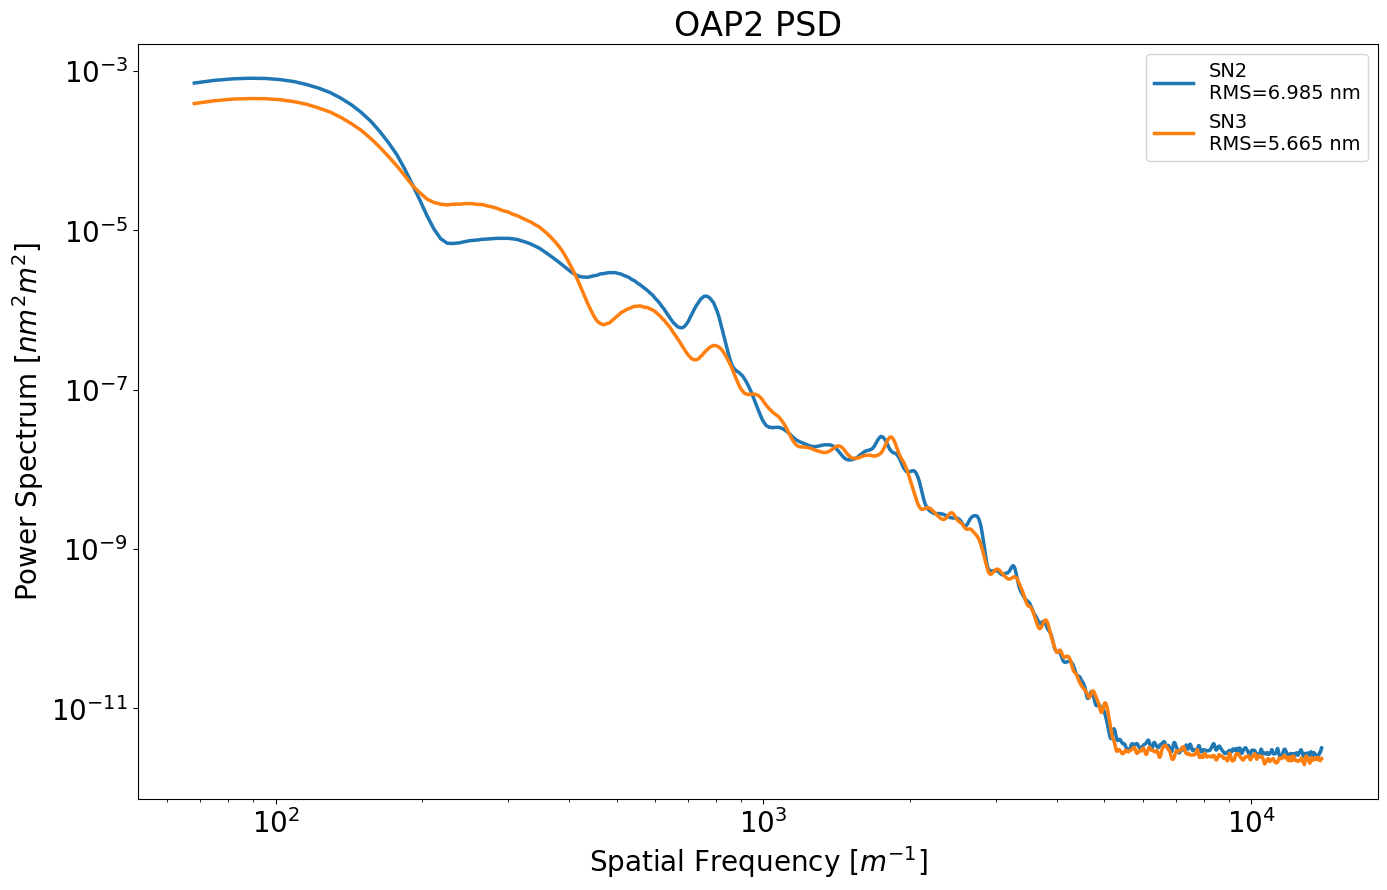

In [4]:
matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[16,10], dpi=100)
for nf in range(0, len(sn_label)):
    plt.loglog(oap[nf].k_radial.value, oap[nf].psd_radial_cal.value, linewidth=2.5,
               label='SN{0}\nRMS={1:.3f}'.format(sn_label[nf], oap[nf].rms_tot))
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
plt.legend(prop={'size':14})#,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('{0} PSD'.format(opt_parms['label']))